# DeepSensor Quickstart

This notebook demonstrates how to use DeepSensor to train a ConvNP model to spatially interpolate ERA5 air temperature data over North America and use the trained model predict air temperature at arbitrary locations.

In [1]:
import logging
logging.captureWarnings(True)

import deepsensor.torch
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP
from deepsensor.active_learning.algorithms import GreedyAlgorithm
from deepsensor.active_learning.acquisition_fns import Stddev

from deepsensor.train.train import Trainer, set_gpu_default_device
from deepsensor.data.utils import construct_x1x2_ds

import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

In [2]:
crs = ccrs.PlateCarree()

use_gpu = True
if use_gpu:
    set_gpu_default_device()

## Load raw data

In [3]:
# Load raw data
ds_raw = xr.tutorial.open_dataset("air_temperature")

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...


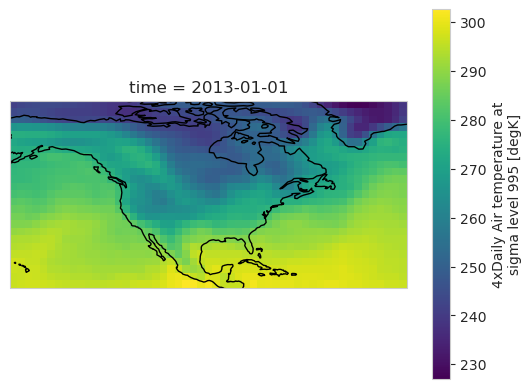

In [4]:
print(ds_raw)
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=crs))
ds_raw.isel(time=0).air.plot()
ax.coastlines()

## Normalise/preprocess data

In [5]:
data_processor = DataProcessor(x1_name="lat", x1_map=(ds_raw["lat"].min(), ds_raw["lat"].max()), x2_name="lon", x2_map=(ds_raw["lon"].min(), ds_raw["lon"].max()))
ds = data_processor(ds_raw)

In [6]:
# Generate auxiliary dataset of x1/x2 coordinates to break translation equivariance in the model's CNN
# to enable learning non-stationarity
x1x2_ds = construct_x1x2_ds(ds)
ds['x1_arr'] = x1x2_ds['x1_arr']
ds['x2_arr'] = x1x2_ds['x2_arr']
aux_ds = ds[['x1_arr', 'x2_arr']]
ds = ds[['air']]

## Set up TaskLoader

In [7]:
task_loader = TaskLoader(context=ds, target=ds)

## Set up ConvNP model

In [8]:
model = ConvNP(data_processor, task_loader, unet_channels=(32,)*3)

dim_yc inferred from TaskLoader: (1,)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
points_per_unit inferred from TaskLoader: 52
encoder_scales inferred from TaskLoader: [0.009615384042263031]
decoder_scale inferred from TaskLoader: 0.019230769230769232


## Generate training tasks

In [9]:
train_tasks = []
for date in pd.date_range("2013-01-01", "2014-11-30")[::7]:
    # Pass up to 10% of grid cells as context and use all grid cells as targets
    task = task_loader(date, context_sampling=np.random.uniform(0.0, 0.1), target_sampling="all")
    train_tasks.append(task)

## Train model

In [10]:
from tqdm import tqdm

n_epochs = 20
losses = []
trainer = Trainer(model, lr=5e-5)
for epoch in tqdm(range(n_epochs)):
    batch_losses = trainer(train_tasks)
    losses.append(np.mean(batch_losses))

100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:36<00:00,  1.83s/it]


Text(0, 0.5, 'Loss')

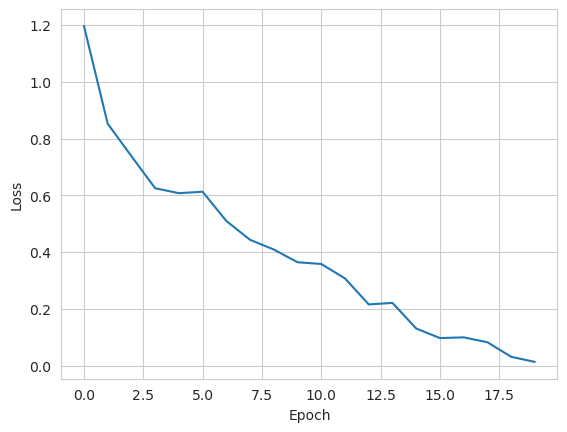

In [11]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

## Perform inference on unseen data

### Targets on a grid: Predict directly to xarray

In [12]:
# Predict on new task with 40 random grid cells passed as context
test_task = task_loader("2014-12-31", 40)
mean_ds, std_ds = model.predict(test_task, X_t=ds_raw)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<xarray.Dataset>
Dimensions:  (time: 1, lat: 25, lon: 53)
Coordinates:
  * time     (time) datetime64[ns] 2014-12-31
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
Data variables:
    air      (time, lat, lon) float32 262.2 261.3 260.4 ... 285.4 284.6 284.3


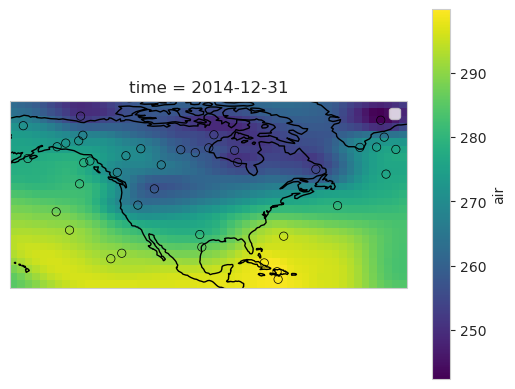

In [13]:
print(mean_ds)
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=crs))
mean_ds.isel(time=0).air.plot(ax=ax)
ax.coastlines()
deepsensor.plot.offgrid_context(ax, test_task, data_processor, task_loader, linewidths=0.5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<xarray.Dataset>
Dimensions:  (time: 1, lat: 25, lon: 53)
Coordinates:
  * time     (time) datetime64[ns] 2014-12-31
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
Data variables:
    air      (time, lat, lon) float32 11.5 11.51 11.47 ... 8.167 8.41 8.521


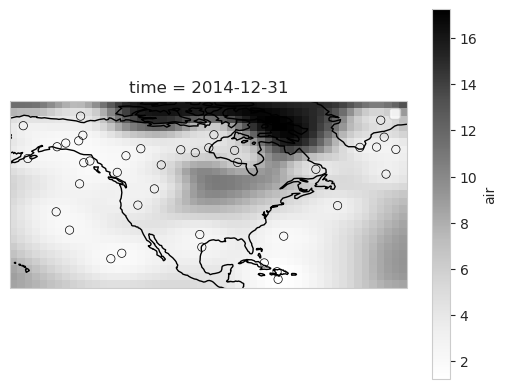

In [14]:
print(std_ds)
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=crs))
std_ds.isel(time=0).air.plot(cmap='Greys')
ax.coastlines()
deepsensor.plot.offgrid_context(ax, test_task, data_processor, task_loader, linewidths=0.5)

### Targets at off-grid points: Predict directly to pandas

In [15]:
# Predict at New York, San Francisco, and Seattle with 40 random (fixed) context points
X_t = np.array([[40.7128, 360-74.0060], [37.7749, 360-122.4194], [47.6062, 360-122.3321]]).T
test_tasks = task_loader(pd.date_range("2014-12-01", "2014-12-31"), 40, seed_override=42)

In [16]:
mean_df, std_df = model.predict(test_tasks, X_t=X_t, append_indexes={"loc": ["new_york", "san_francisco", "seattle"]})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


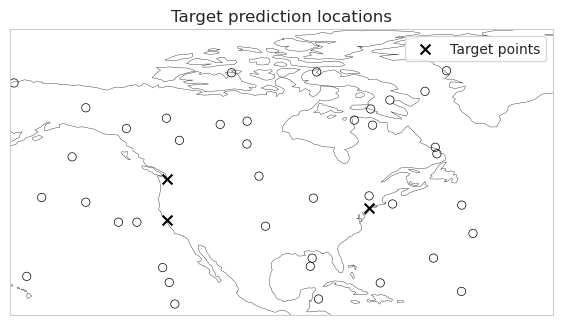

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw=dict(projection=crs))
extent = [ds_raw["lon"].min(), ds_raw["lon"].max(), ds_raw["lat"].min(), ds_raw["lat"].max()]
ax.set_extent(extent)
ax.coastlines(linewidth=0.25)
deepsensor.plot.offgrid_context(ax, test_tasks[0], data_processor, task_loader, linewidths=0.5)
ax.scatter(X_t[1, :], X_t[0, :], marker="x", color="black", s=50, label="Target points")
ax.legend()
ax.set_title("Target prediction locations")
plt.show()

                                                  air
time       lat     lon      loc                      
2014-12-01 40.7128 285.9940 new_york       282.297333
           37.7749 237.5806 san_francisco  288.258331
           47.6062 237.6679 seattle        271.727539
2014-12-02 40.7128 285.9940 new_york       278.472534
           37.7749 237.5806 san_francisco  288.115417
...                                               ...
2014-12-30 37.7749 237.5806 san_francisco  284.650726
           47.6062 237.6679 seattle        270.528442
2014-12-31 40.7128 285.9940 new_york       269.426208
           37.7749 237.5806 san_francisco  283.707062
           47.6062 237.6679 seattle        273.596985

[93 rows x 1 columns]


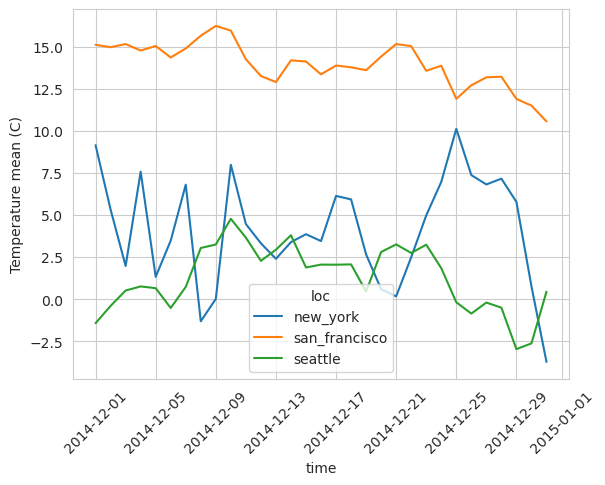

In [18]:
print(mean_df)
ax = sns.lineplot(data=mean_df-273.15, x="time", y="air", hue="loc")
ax.set_ylabel("Temperature mean (C)")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

                                                air
time       lat     lon      loc                    
2014-12-01 40.7128 285.9940 new_york       2.508516
           37.7749 237.5806 san_francisco  2.656277
           47.6062 237.6679 seattle        6.130956
2014-12-02 40.7128 285.9940 new_york       2.826341
           37.7749 237.5806 san_francisco  2.684553
...                                             ...
2014-12-30 37.7749 237.5806 san_francisco  2.952368
           47.6062 237.6679 seattle         6.51846
2014-12-31 40.7128 285.9940 new_york       3.478682
           37.7749 237.5806 san_francisco  3.072842
           47.6062 237.6679 seattle        5.660307

[93 rows x 1 columns]


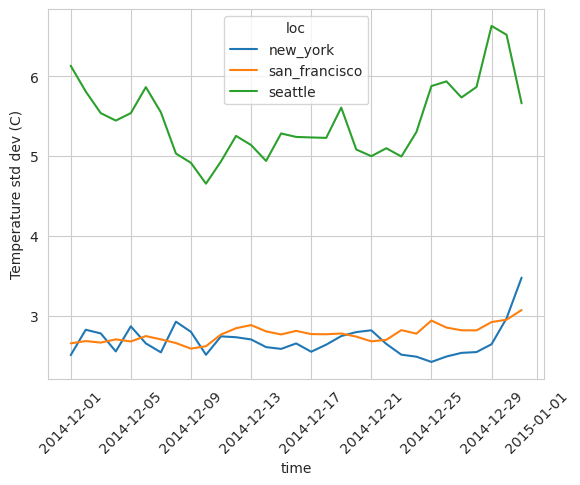

In [19]:
print(std_df)
ax = sns.lineplot(data=std_df, x="time", y="air", hue="loc")
ax.set_ylabel("Temperature std dev (C)")
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

## Perform active learning

Use a greedy algorithm to propose locations for new context points.
Here we'll use the model 's standard deviation at search points as the acquisition function. Maximising this acquisition function will place context points at locations where the model is most uncertain.

In [21]:
greedy_alg = GreedyAlgorithm(
    model=model,
    X_t=ds_raw,
    X_s=ds_raw,
    N_new_context=10,
)

test_task = task_loader("2014-12-31", 20)
acquisition_fn = Stddev(model)
X_new_df, acquisition_fn_ds = greedy_alg(acquisition_fn, test_task)

In [22]:
X_new_df

,x1,x2
iteration,,
0,65.0,290.0
1,75.0,300.0
2,75.0,262.5
3,75.0,225.0
4,52.5,265.0
5,62.5,267.5
6,75.0,280.0
7,67.5,330.0
8,75.0,312.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


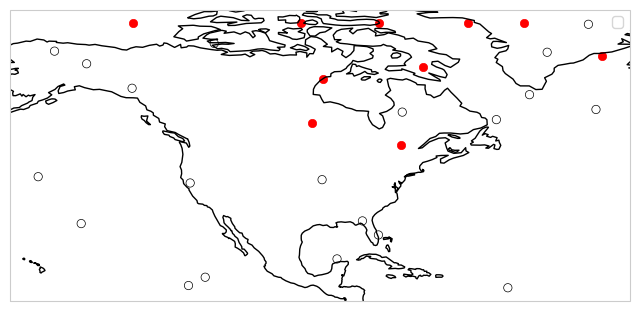

In [23]:
fig = deepsensor.plot.placements(test_task, X_new_df, data_processor, crs, figsize=8)